This notebook expands on the latent factor model with features by accounting for anime with genres of "N/A," taken to be anime with unknown genres. I use the Expectation Algorithm (EM) algorithm to come up with an estimate for the best genre representation of the shows with unknown genres. In our model, the "unobserved variables" are the missing genres. We want to find the MLE for our data, but that's complicated by us needing to find a likely configuration of the unobserved variables (i.e. finding a which genres fit the anime).

The expectation (E) step is an inference step. Each anime has a one hot encoding for each genre. If the anime falls under the genre, it is 1 and if it does not, it is 0. The aim in the E step is to find, for each anime without genre information, the probability (0 to 1) it falls under a particular genre. This probability is derived from our latent factor model.

The maximization (M) step simply looks to maximize the likelihood of the data, i.e. it's simply minimizing our normal objective from the LFM with features. Note that for the anime with unknown genres, we are using the inferenced 

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline
matplotlib.style.use('seaborn')

In [8]:
import pandas as pd

In [9]:
from animerec.data import get_data
users, anime = get_data()

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(users, test_size = 0.1) #let's split up the dataset into a train and test set.
train, valid = train_test_split(train, test_size = 0.2) #let's split up the dataset into a train and valid set.

In [11]:
from animerec.data import remove_users
train = remove_users(train, 10)

In [12]:
#define validation set
valid_users = valid['user_id']
valid_anime = valid['anime_id']
valid_ratings = valid['rating']

In [7]:
genres = anime.genre.apply(lambda x: str(x).split(","))
genres2 = genres.apply(pd.Series)
all_genres = []
for i in range(len(genres2.columns)):
    genres2[i] = genres2[i].str.strip()
    all_genres += map(lambda s: str(s).strip(), list(genres2[i].unique()))
all_genres = list(np.unique(all_genres))

In [8]:
genre_map = {}
for i, x in enumerate(all_genres): genre_map.update({x:i})
nGenres = len(all_genres)

In [9]:
indexed = anime.set_index('anime_id')
indexed.index.name = None
ind = indexed.ix[train.anime_id.get_values()]

In [10]:
train_genres = ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

In [11]:
ohe_genres = np.zeros((len(train_genres), nGenres))
for i, row in enumerate(train_genres): ohe_genres[i, row] = 1


In [27]:
v_ind = indexed.ix[valid.anime_id.get_values()]
valid_genres = v_ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

v_ohe_genres = np.zeros((len(valid_genres), nGenres))
for i, row in enumerate(valid_genres): v_ohe_genres[i, row] = 1



In [32]:
test_ind = indexed.ix[test.anime_id.get_values()]
test_genres = test_ind.genre.map(lambda x: [genre_map[j.strip()] for j in str(x).split(',')])

test_ohe_genres = np.zeros((len(test_genres), nGenres))
for i, row in enumerate(test_genres): test_ohe_genres[i, row] = 1




In [12]:
#initialize some local variables
nUsers = len(train.user_id.unique())
nAnime = len(train.anime_id.unique())

# we'll need some data structures in order to vectorize computations
from collections import defaultdict
user_ids = train.user_id
item_ids = train.anime_id

user_index = defaultdict(lambda: -1) # maps a user_id to the index in the bias term.
item_index = defaultdict(lambda: -1) # maps an anime_id to the index in the bias term.

counter = 0
for user in user_ids:
    if user_index[user] == -1:
        user_index[user] = counter
        counter += 1 

counter = 0
for item in item_ids:
    if item_index[item] == -1:
        item_index[item] = counter
        counter += 1 

In [13]:
#Terms needed for the latent factors.
k = 3; # hyper-parameter

In [14]:
import tensorflow as tf

In [15]:
y = tf.cast(tf.constant(train['rating'].as_matrix(), shape=[len(train),1]), tf.float32)

In [20]:
def objective(alpha, Bi, Bu, Gi, Gu, Pi, y, lam): #Gi, Gu = gamma_i, gamma_u = latent factors for items, users 
    
    '''
    Like in the linear model, we need to construct the "full" matrix for each (user, item) pair. However, with the
    addition of the latent factor terms, it will waste memory to hold each variable in its own tensor.
    Instead, create one intermediary tensor to represent our prediction ("pred") and simply incrementally add to that
    each additional variable.
    '''
    pred = tf.gather(Bi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #Bi_full
    pred += tf.gather(Bu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #Bu_full
    
    Gi_full = tf.gather(Gi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #latent factors of items
    Gu_full = tf.gather(Gu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #latent factors of users

    Pi_full = tf.matmul(tf.constant(ohe_genres, dtype=tf.float32), Pi) 
    
    pred += tf.expand_dims(tf.einsum('ij,ji->i', (Gi_full+Pi_full), tf.transpose(Gu_full)), 1)

    pred += tf.tile(alpha, (len(train), 1)) #alpha_full
    obj = tf.reduce_sum(abs(pred-y))


    # regularization
    obj += lam * tf.reduce_sum(Bi**2)
    obj += lam * tf.reduce_sum(Bu**2) 
    obj += lam * tf.reduce_sum(Gi**2) 
    obj += lam * tf.reduce_sum(Gu**2)
    
    return obj

In [17]:
#initialize alpha, Bi, Bu, Gi, Gu 
alpha = tf.Variable(tf.constant([6.9], shape=[1, 1]))
Bi = tf.Variable(tf.constant([0.0]*nAnime, shape=[nAnime, 1]))
Bu = tf.Variable(tf.constant([0.0]*nUsers, shape=[nUsers, 1]))
Gi = tf.Variable(tf.random_normal([nAnime, k], stddev=0.35))
Gu = tf.Variable(tf.random_normal([nUsers, k], stddev=0.35))
Pi = tf.Variable(tf.random_normal([nGenres, k], stddev=0.35))

In [18]:
optimizer = tf.train.AdamOptimizer(0.01)

In [21]:
obj = objective(alpha, Bi, Bu, Gi, Gu, Pi, y, 1)

In [22]:
trainer = optimizer.minimize(obj)

In [29]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
tLoss = []
vLoss = []
prev = 10e10
for iteration in range(500):
    cvalues = sess.run([trainer, obj])
    print("objective = " + str(cvalues[1]))
    tLoss.append(cvalues[1])
    
    if not iteration % 5:
        cAlpha, cBi, cBu, cGi, cGu, cPi, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, Pi, obj])
        indices = valid_users.map(lambda x: user_index[x])
        bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
        gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
        gu = np.vstack(gu.as_matrix()).astype(np.float)


        indices = valid_anime.map(lambda x: item_index[x])
        bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
        gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
        gi = np.vstack(gi.as_matrix()).astype(np.float)
        
        pi = np.dot(v_ohe_genres, cPi) 


        g = np.einsum('ij,ji->i', (gi+pi), np.transpose(gu)) 

        preds = bu + bi + g + float(cAlpha)
        MAE = 1.0/len(valid) * sum(abs(valid_ratings-preds))
        vLoss.append(MAE)
        if MAE > prev: break
        else: prev = MAE
    
cAlpha, cBi, cBu, cGi, cGu, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, obj])
print("\nFinal train loss is ", cLoss)

objective = 4.72971e+06
objective = 4.65157e+06
objective = 4.57885e+06
objective = 4.51098e+06
objective = 4.44739e+06
objective = 4.38763e+06
objective = 4.33127e+06
objective = 4.27776e+06
objective = 4.22652e+06
objective = 4.17695e+06
objective = 4.12846e+06
objective = 4.08043e+06
objective = 4.03236e+06
objective = 3.98387e+06
objective = 3.93464e+06
objective = 3.88456e+06
objective = 3.83368e+06
objective = 3.78225e+06
objective = 3.73062e+06
objective = 3.67929e+06
objective = 3.62886e+06
objective = 3.57987e+06
objective = 3.53282e+06
objective = 3.48803e+06
objective = 3.44569e+06
objective = 3.40578e+06
objective = 3.36805e+06
objective = 3.33226e+06
objective = 3.29808e+06
objective = 3.26521e+06
objective = 3.23343e+06
objective = 3.20264e+06
objective = 3.17288e+06
objective = 3.14423e+06
objective = 3.11687e+06
objective = 3.09097e+06
objective = 3.0667e+06
objective = 3.04414e+06
objective = 3.02332e+06
objective = 3.00416e+06
objective = 2.9865e+06
objective = 2.9701

Let's plot the objective and see how it decreases.

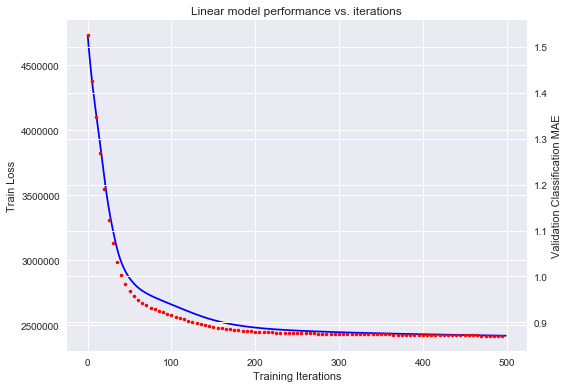

In [30]:
fig, ax1 = plt.subplots()
plt.title('Linear model performance vs. iterations')
ax1.plot(tLoss, 'b-')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Train Loss')

ax2 = ax1.twinx()
ax2.plot(range(0, len(vLoss)*5, 5), vLoss, 'r.')
ax2.set_ylabel('Validation Classification MAE')

fig.tight_layout()

We can see quite clearly that this model does not overfit, just like the linear model. L2 regularization looks to be more than enough. However, we also can see that after about 150 iterations, validation MAE mostly flatlines, which suggests a place for early stopping. 

Let's test the model on our test data now.

In [33]:
test_users = test['user_id']
test_anime = test['anime_id']
test_ratings = test['rating']

In [34]:
indices = test_users.map(lambda x: user_index[x])
bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
gu = np.vstack(gu.as_matrix()).astype(np.float)

indices = test_anime.map(lambda x: item_index[x])
bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
gi= np.vstack(gi.as_matrix()).astype(np.float)
pi = np.dot(test_ohe_genres, cPi) 


g = np.einsum('ij,ji->i', (gi+pi), np.transpose(gu)) 

preds = bu + bi + g + float(cAlpha)
MAE = 1.0/len(test) * sum(abs(test_ratings-preds))
print ('MAE on test set is: ', float(MAE))

MAE on test set is:  0.8685068394580536


In [ ]:
sess.close()

So, an improvement over the basic latent factor model. What's cool about this model is that in addition